In [ ]:
import os
import tqdm
import torch
import random
import librosa
import torchaudio
import numpy as np
from torch import nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torchaudio import transforms
from torch.utils.data import DataLoader
from torch.utils.data.dataset import random_split
from torch.utils.data import DataLoader, Dataset,TensorDataset
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score

In [ ]:
# Get cpu, gpu or mps device for training.
DEVICE = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {DEVICE} device")


Using cuda device


DATA

In [ ]:
class AudioDataset(Dataset):
    def __init__(self, data_dir, is_label, TARGET_SAMPLE_RATE = 16000):
        #is label = True para audios com label, False para audios sem label, isso garante que mudanças no pipeline de extração de features sejam para ambos os conjuntos
        self.data_dir = data_dir
        self.classes = ["real", "fake"]
        self.audio_files = []
        self.labels = []
        self.is_label = is_label
        self.TARGET_SAMPLE_RATE =TARGET_SAMPLE_RATE
        if self.is_label:
            for class_idx, class_name in enumerate(self.classes):
                class_dir = os.path.join(data_dir, class_name)
                for file in os.listdir(class_dir):
                    if file.endswith(".mp3"):
                        self.audio_files.append(os.path.join(class_dir, file))
                        self.labels.append(class_idx)
        else:
            for file in os.listdir(self.data_dir):
                if file.endswith(".mp3"):
                    self.audio_files.append(os.path.join(self.data_dir,file))

        self.mel_spectrogram = torchaudio.transforms.MelSpectrogram(
            sample_rate=TARGET_SAMPLE_RATE, n_fft=1024, hop_length=512, n_mels=64
        )

    def __len__(self):
        return len(self.audio_files)

    def __getitem__(self, idx):
        audio_file = self.audio_files[idx]
        if self.is_label:
            label = self.labels[idx]

        # Load audio
        audio, sr = torchaudio.load(audio_file)
        # Convert to mono
        if audio.shape[0] > 1:
            audio = torch.mean(audio, dim=0).unsqueeze(0)

        if sr != self.TARGET_SAMPLE_RATE:
            audio = torchaudio.transforms.Resample(sr, self.TARGET_SAMPLE_RATE)(audio)

        # Pad or truncate the audio to a fixed length
        fixed_length = (
            self.TARGET_SAMPLE_RATE * 3
        )  # Adjust this value based on your requirements
        if audio.shape[1] < fixed_length:
            audio = torch.nn.functional.pad(audio, (0, fixed_length - audio.shape[1]))
        else:
            audio = audio[:, :fixed_length]

        audio = self.mel_spectrogram(audio)
        if self.is_label:
            return audio, label
        else:
            #import for test generating
            return audio, os.path.basename(audio_file)

DataLoader

In [ ]:
class Data:

    def __init__(self, batch_size,dataset_train,dataset_test, do_split):
        self.modes = ['train','test']
        self.dataloaders = {}
        self.batch_size = batch_size
        self.do_split = do_split
        if self.do_split:
            self.modes = ['train','validation','test']
            generator = torch.Generator().manual_seed(42)
            train_size = int(len(dataset_train.audio_files)*0.8)
            val_size = int(len(dataset_train.audio_files)-train_size)
            train_set, val_set = random_split(dataset_train, [train_size, val_size], generator=generator)

            self.dataloaders['train'] = train_set
            self.dataloaders['validation'] = val_set
        else:
            self.dataloaders['train'] = dataset_train

        self.dataloaders['test'] = dataset_test


    def get_loader(self, mode):
        if mode == 'train':
            return  DataLoader(self.dataloaders[mode], batch_size=self.batch_size, shuffle=True)
        else:
            return  DataLoader(self.dataloaders[mode], batch_size=self.batch_size, shuffle=False)


Evaluator

In [ ]:
class Evaluator:

    def __init__(self):

        self.loss_fn = nn.BCELoss()
    def get_loss(self, y, y_hat):
        return self.loss_fn(y_hat, y)

Model

In [ ]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.stride = stride

        # Add a 1x1 convolution if the input channel size does not match the output channel size
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )
        else:
            self.shortcut = nn.Sequential()

    def forward(self, x):
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        out += self.shortcut(x)
        out = self.relu(out)
        return out

In [ ]:
class ResNet(nn.Module):
    def __init__(self, input_size):
        super(ResNet, self).__init__()
        self.in_channels = 16
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(16)
        self.relu = nn.ReLU(inplace=True)
        self.layer1 = self.make_layer(16, 2)
        self.layer2 = self.make_layer(32, 2, stride=2)
        self.layer3 = self.make_layer(64, 2, stride=2)
        self.layer4 = self.make_layer(128, 2, stride=2)
        self.avg_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(128, 1)

    def make_layer(self, out_channels, blocks, stride=1):
        layers = []
        layers.append(ResidualBlock(self.in_channels, out_channels, stride))
        self.in_channels = out_channels
        for _ in range(1, blocks):
            layers.append(ResidualBlock(out_channels, out_channels))
        return nn.Sequential(*layers)

    def forward(self, x):
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.avg_pool(out)
        out = out.view(out.size(0), -1)
        out = self.fc(out)
        out = torch.sigmoid(out)
        return out

In [ ]:
class NeuralNetwork(nn.Module):
    def __init__(self, input_size):
        super(NeuralNetwork, self).__init__()
        self.input_size = input_size
        self.conv_layer = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        dummy_tensor = self.conv_layer(torch.zeros(self.input_size).unsqueeze(0))
        dim = 1
        for d in dummy_tensor.shape[1:]:
            dim *= d
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(dim, 1)
        )

    def forward(self, x):
        x = self.conv_layer(x)
        x = self.flatten(x)
        x = self.linear_relu_stack(x)
        x = torch.sigmoid(x)
        return x


Learner

In [ ]:
class Learner:
    def __init__(self, input_size):
        self.model = ResNet(input_size=input_size)
        self.model.to(DEVICE)
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=1e-3)

    def predict(self, x):
        return self.model(x)

    def update(self, loss):
        # Backpropagation
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

Metrics e best models

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score

class Metrics2():
    #FOR TRAIN AND VALIDATION ONLY
    def __init__(self):
        self.metrics_save = {}
        self.best_models_weigths = {}
        self.metrics_names  = ['accuracy', 'recall', 'precision', 'f1-score']

    def calc_metrics(self, preds, labels, mode, loss, model_weights=None, show=False):
        acc = accuracy_score(y_pred=preds, y_true=labels)
        recall = recall_score(y_pred=preds, y_true=labels)
        precision = precision_score(y_pred=preds, y_true=labels)
        f1 = f1_score(y_pred=preds, y_true=labels, average='binary')
        metrics_values = [acc, recall, precision, f1]

        # Save loss
        if f'{mode}_loss' not in self.metrics_save.keys():
            self.metrics_save[f'{mode}_loss'] = [loss]
        else:
            self.metrics_save[f'{mode}_loss'].append(loss)

        # Print metrics if show is True
        if show:
            print(f"{mode.capitalize()} - Accuracy: {acc:.2f} - Recall: {recall:.2f} - Precision: {precision:.2f} - F1-Score: {f1:.2f} - Loss: {loss:.2f}")

        # Save metrics
        for metric_name, metric_value in zip(self.metrics_names, metrics_values):
            if f'{mode}_{metric_name}' not in self.metrics_save.keys():
                self.metrics_save[f'{mode}_{metric_name}'] = [metric_value]
            else:
                self.metrics_save[f'{mode}_{metric_name}'].append(metric_value)

            # Save best metrics and respective weights
            if mode == 'train':
                if f'{mode}_best_{metric_name}' not in self.metrics_save.keys():
                    self.metrics_save[f'{mode}_best_{metric_name}'] = metric_value
                    self.best_models_weigths[f'{mode}_best_{metric_name}'] = model_weights
                elif metric_value > self.metrics_save[f'{mode}_best_{metric_name}']:
                    self.metrics_save[f'{mode}_best_{metric_name}'] = metric_value
                    self.best_models_weigths[f'{mode}_best_{metric_name}'] = model_weights

    def plot_metrics(self, iteration):
        fig, axs = plt.subplots(2, 2, figsize=(10, 10))
        metrics = self.metrics_names.copy()
        modes = ['train', 'validation']
        for i, metric_name in enumerate(metrics):
            for mode in modes:
                metric_values = self.metrics_save[f'{mode}_{metric_name}']
                axs[i // 2, i % 2].plot(np.arange(iteration), metric_values, label=mode)

                axs[i // 2, i % 2].set_title(f'{metric_name.capitalize()}: {modes[0]} x {modes[1]}')
                axs[i // 2, i % 2].set_xlabel('Iteration')
                axs[i // 2, i % 2].set_ylabel(metric_name.capitalize())
                axs[i // 2, i % 2].legend()

        plt.tight_layout()
        plt.show()

    def plot_loss(self, iteration):
        modes = ['train', 'validation']
        metric_name = 'loss'
        fig, axs = plt.subplots(1, 1, figsize=(6, 6))
        for mode in modes:
            metric_values = np.exp(self.metrics_save[f'{mode}_{metric_name}'])
            axs.plot(np.arange(iteration), metric_values, label=mode)

        axs.set_title(f'Log scale {metric_name.capitalize()}: {modes[0]} x {modes[1]}')
        axs.set_xlabel('Iteration')
        axs.set_ylabel(metric_name.capitalize())
        axs.legend()

        plt.tight_layout()
        plt.show()

    def get_best_model(self, metric):
        for key in self.best_models_weigths.keys():
            if metric in key:
                return self.best_models_weigths[key]

    def save_best_model(self, all_metrics, metric='f1-score'):
        if all_metrics:
            print("Saving all models")
            for key in self.best_models_weigths.keys():
                torch.save(f'{self.best_models_weigths[key]}.pt', key)
                print(f"Saved model at: {key}.pt")

        else:
            print(f"Saving best model for {metric}")
            for key in self.best_models_weigths.keys():
                if metric in key:
                    torch.save(f'{self.best_models_weigths[key]}.pt', key)
                    print(f"Saved model at: {key}.pt")
                    break


In [ ]:
class Metrics():
    #FOR TRAIN AND VALIDATION ONLY
    def __init__(self):
        self.metrics_save = {}
        self.best_models_weigths = {}
        self.metrics_names  = ['acuracy','recall','precision','f1-score']

    def calc_metrics(self,preds,labels,mode,loss, model_weigths=None, show=False):
        acc = accuracy_score(y_pred=preds, y_true=labels)
        recall = recall_score(y_pred=preds, y_true=labels)
        precision = precision_score(y_pred=preds, y_true=labels)
        f1 = f1_score(y_pred=preds, y_true=labels,average='binary')
        metrics_values = [acc,recall,precision,f1]


        ###################LOSS#############################################
        if f'{mode}_loss' not in self.metrics_save.keys():
            self.metrics_save[f'{mode}_loss'] = [loss]
        else:
            self.metrics_save[f'{mode}_loss'].append(loss)
        ################################################################

        if show:
            print(f"{mode} -  Acuracy: {acc:.2f} - Recall {recall:.2f} - Precision {precision:.2f} - F1-Score {f1:.2f} - Loss {loss:.2f}")


        #############Metrics##################################################

        for metric_name, metric_value in zip(self.metrics_names, metrics_values):

            ###Add metrics
            if f'{mode}_{metric_name}' not in self.metrics_save.keys():
                self.metrics_save[f'{mode}_{metric_name}'] = [metric_value]
            else:
                self.metrics_save[f'{mode}_{metric_name}'].append(metric_value)

            ###Sava best metrics and respective weigths
            if mode == 'train':
                if f'{mode}_best_{metric_name}' not in self.metrics_save.keys():
                    self.metrics_save[f'{mode}_best_{metric_name}'] = metric_value
                    self.best_models_weigths[f'{mode}_best_{metric_name}'] = model_weigths
                elif metric_value > self.metrics_save[f'{mode}_best_{metric_name}'] :
                    self.best_models_weigths[f'{mode}_best_{metric_name}'] = model_weigths

        ################################################################


    def plot_metrics(self):
        fig, axs = plt.subplots(2, 2, figsize=(10, 10))
        metrics = self.metrics_names.copy()
        modes = ['train','validation']
        for i,metric_name in enumerate(metrics):
            metric_train  = self.metrics_save[f'{modes[0]}_{metric_name}']
            metric_validation  = self.metrics_save[f'{modes[1]}_{metric_name}']

            ii = i % 2
            jj = i // 2
            axs[jj,ii].plot(metric_train, label=modes[0])
            axs[jj,ii].plot(metric_validation, label=modes[1])

            axs[jj,ii].set_title(f'{metric_name}: {modes[0]} x {modes[1]}')
            axs[jj,ii].set_xlabel('Epoch')
            axs[jj,ii].set_ylabel(f'{metric_name}')
            axs[jj,ii].legend()

        plt.tight_layout()

        # Mostrar o plot
        plt.show()

    def plot_loss(self):
        modes = ['train','validation']
        metric_name = 'loss'
        metric_train  = np.exp(self.metrics_save[f'{modes[0]}_{metric_name}'])
        metric_validation  = np.exp(self.metrics_save[f'{modes[1]}_{metric_name}'])
        fig, axs = plt.subplots(1, 1, figsize=(6, 12))
        i = 0
        axs[i,i].set_title(f'Log scale {metric_name}: {modes[0]} x {modes[1]}')
        axs[i,i].plot(metric_train, label=modes[0])
        axs[i,i].plot(metric_validation, label=modes[1])
        axs[i,i].set_xlabel('Epoch')
        axs[i,i].set_ylabel(f'{metric_name}')
        axs[i,i].legend()

        plt.tight_layout()
        # Mostrar o plot
        plt.show()

    def get_best_model(self, metric):
        for key in self.best_models_weigths.keys():
                if metric in key:
                    return self.best_models_weigths[key]

    def save_best_model(self,all_metrics, metric='F1-Score'):
        if all_metrics:
            print("Saving all models")
            for key in self.best_models_weigths.keys():
                torch.save(f'{self.best_models_weigths[key]}.pt', key)
                print(f"Save model at: {key}.pt")

        else:
            print(f"Saving best model for {metric}")
            for key in self.best_models_weigths.keys():
                if metric in key:
                    torch.save(f'{self.best_models_weigths[key]}.pt', key)
                    print(f"Save model at: {key}.pt")
                    break


Trainer

In [ ]:
class Trainer:
    def __init__(self, data: Data, learner: Learner, evaluator: Evaluator, metrics: Metrics):
        self.data = data
        self.learner = learner
        self.metrics = metrics
        self.evaluator = evaluator

    def one_epoch(self, mode):
        if mode == 'train':
            self.learner.model.train(True)
        else:
            self.learner.model.train(False)


        dataloader = self.data.get_loader(mode)
        preds = []
        labels = []
        epoch_loss = 0

        for (X, y) in tqdm.tqdm(dataloader):
            X, y = X.to(DEVICE), y.to(DEVICE).float().unsqueeze(1)

            y_hat = self.learner.predict(X)

            loss = self.evaluator.get_loss(y, y_hat)
            epoch_loss += loss.item()

            if mode == 'train':
                self.learner.update(loss)

            labels.extend(y.int().tolist())
            preds.extend((y_hat > 0.5).int().tolist())

        epoch_loss /= len(dataloader)

        #preds,labels,mode,loss, model_weigths=None, show=False
        self.metrics.calc_metrics(preds=preds, labels=labels, mode=mode, loss=epoch_loss, model_weigths=self.learner.model.state_dict(), show=True)

    def test(self,mode,name_test, model_weigths=None):
        self.learner.model.load_state_dict(model_weigths)
        self.learner.model.train(False)
        dataloader = self.data.get_loader(mode)
        preds = []
        ids = []
        for (X, x_id) in tqdm.tqdm(dataloader):
            X = X.to(DEVICE)
            y_hat = self.learner.predict(X)
            ids.extend(x_id)
            preds.extend((y_hat).float().tolist())

        file_test_submtion =  open(f'{name_test}.csv','w')
        file_test_submtion.write('id,fake_prob\n')
        for idx,pred in zip(ids,preds):
            file_test_submtion.write(f"{idx},{pred[0]}\n")
        print(f"Test submission for {name_test} saved at {name_test}.csv")


    def run(self, n_epochs: int):
        print("Starting training")
        for t in range(n_epochs):
            print(f"Epoch {t+1}\n-------------------------------")
            self.one_epoch(mode='train')

            with torch.no_grad():
                self.one_epoch(mode='validation')
        print("Training done")

    def run_test(self,name_test):
        #Keep test at the end of training
        metric = 'f1-score'
        print(f"Generating test probs with {metric} best model:")
        with torch.no_grad():
            best_model = self.metrics.get_best_model(metric=metric)
            self.test(mode='test', name_test=name_test, model_weigths=best_model)


DATA


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip /content/drive/MyDrive/PAV/competition/deepfake-detection-ufg.zip

Run training

instancias

In [ ]:
#datasets
audio_train = AudioDataset(data_dir='/content/audios/train', is_label=True)
audio_teste = AudioDataset(data_dir='/content/audios/test', is_label=False)


In [ ]:
#dataloaders
data =Data(batch_size=100, dataset_train=audio_train, dataset_test=audio_teste, do_split=True)


In [ ]:
#evaluator
evaluator = Evaluator()

In [ ]:
#learner
learner = Learner(input_size=(1,64,94))

In [ ]:
metrics = Metrics2()

Treino

In [ ]:
trainer = Trainer(data=data, evaluator=evaluator, learner=learner, metrics=metrics)
trainer.run(n_epochs=10)
trainer.run_test(name_test='test_cnn_baseline')

Starting training
Epoch 1
-------------------------------


  9%|▉         | 4/43 [00:05<00:49,  1.28s/it]


KeyboardInterrupt: 

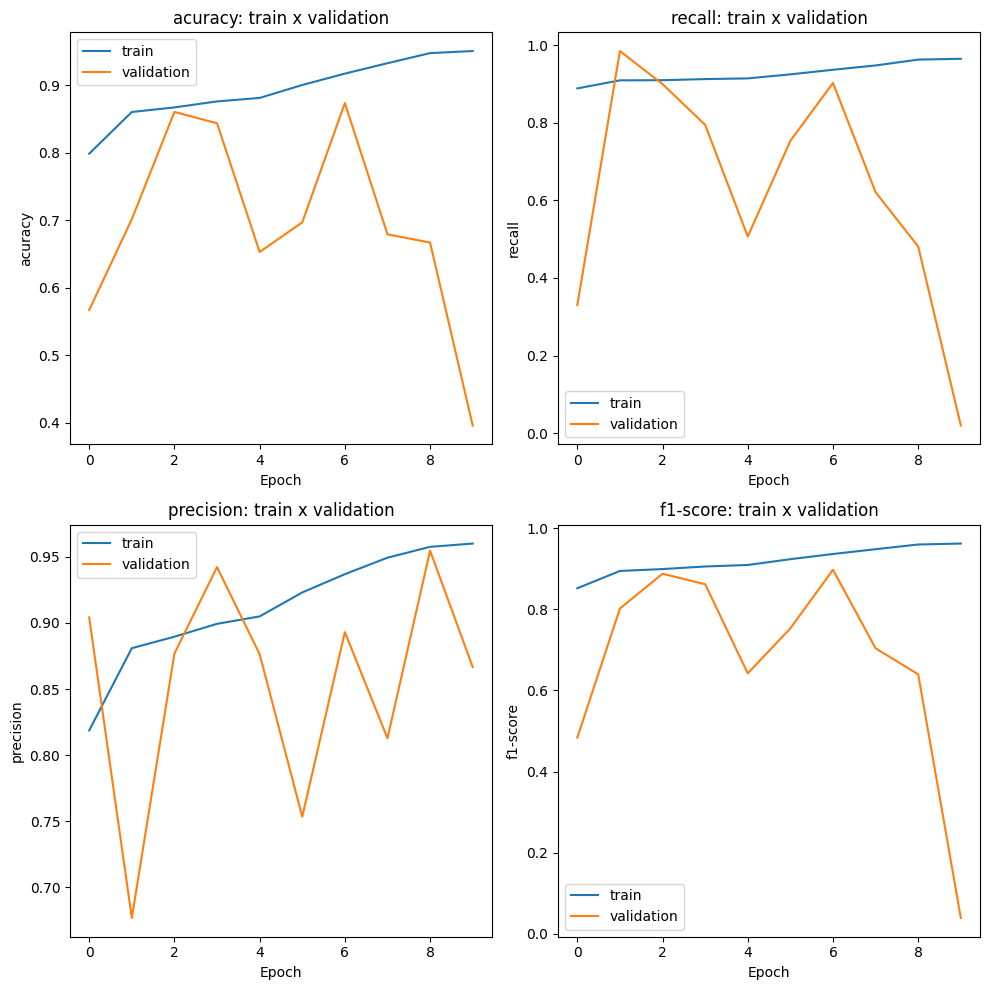

In [ ]:
metrics.plot_metrics()

In [ ]:
metrics.plot_loss()

In [ ]:
#save all metrics
metrics.save_best_model(all_metrics=True)

Saving all models
Save model at: train_best_acuracy.pt
Save model at: train_best_recall.pt
Save model at: train_best_precision.pt
Save model at: train_best_f1-score.pt


In [ ]:
#save only one metric
metrics.save_best_model(all_metrics=False, metric='recall')

Saving best model for recall
Save model at: train_best_recall.pt
